## Tabel of Contents:
* [1 Case 3. Patient Drug Review](#case-3)
* [2 Background](#case-background)
* [3 Data](#loading-data)
* [4 Data Preprocessing](#data-preprocessing)
* [5 Models and Training](#models-trainning)
* [6 Conclusions](#cas-conclusion)

# Case 3. Patient Drug Review <a class="anchor" id="case-3"></a>
Team 14:<br>
* Awet Ghebreslassie
* Leevi Pelkonen
* Visa Soininen<br><br>
Last edited: 02.02.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

# 2 Background  <a class="anchor" id="case-background"></a>

The aim of this Notebook is to predict the rating of a drug based on a review.

# 3 Data  <a class="anchor" id="loading-data"></a>

The dataset is from: [UCI ML Drug Review dataset](https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018).

In [6]:
# imports
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

Populating the interactive namespace from numpy and matplotlib


In [7]:
# Create dataframes train and test data

train_data = pd.read_csv("data/drugsComTrain_raw.csv")
test_data = pd.read_csv("data/drugsComTest_raw.csv")

train_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


# 4 Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

We will simplify the rating labels down to just three different classes: “negative” (rating < 5), “neutral” (rating 5 or 6) and “positive” (rating > 6) as per task suggention.

In [8]:
# Create three categories
# label = 2, when rating = > 6
# label = 1, when rating = 5 or 6
# label = 0, when rating = < 5
train_data['rating'] = np.where(train_data['rating'] > 6, 2, (np.where(train_data['rating'] < 5, 0, 1)))
test_data['rating'] = np.where(test_data['rating'] > 6, 2, (np.where(test_data['rating'] < 5, 0, 1)))

train_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",2,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",2,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",1,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",2,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",2,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",0,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",0,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",2,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",0,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",2,8-Dec-16,1


Since we are only intersted on review column and rating column we will extract only this data from our dataframes.

In [9]:
# extracting review values
train_samples = train_data['review'].values.tolist()
test_samples = test_data['review'].values.tolist()

# extracting rating/label values
train_labels = train_data['rating'].values
test_labels = test_data['rating'].values

One-hot encode categorical data

In [10]:
# Convert outputs to one-hot-coded categoricals

from tensorflow.keras.utils import to_categorical

train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

print(train_labels_cat[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [11]:
# Tokenize the text

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_samples)

In [12]:
# Convert reviews to integer sequences

train_sequences = tokenizer.texts_to_sequences(train_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)
print(train_sequences[0])

[5, 38, 28, 35, 197, 1, 45, 5, 15, 848, 12, 2922, 99, 150, 2, 3806, 1551]


In [13]:
# Pad the reviews to have the same length

from tensorflow.keras import preprocessing

maxlen = 100

train_sequences = preprocessing.sequence.pad_sequences(train_sequences, maxlen = maxlen)
test_sequences = preprocessing.sequence.pad_sequences(test_sequences, maxlen = maxlen)
print(train_sequences[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    5
   38   28   35  197    1   45    5   15  848   12 2922   99  150    2
 3806 1551]


# 5 Models and training  <a class="anchor" id="models-trainning"></a>

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN

In [15]:
# Use word vectors of dimension 16, flatten and feed straight to output layer

model = Sequential()
model.add(Embedding(5000, 16, input_length = maxlen))
model.add(Flatten())
model.add(Dense(3, activation = 'softmax'))

In [16]:
# Compile the model
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

In [17]:
# Train the model
history = model.fit(train_sequences, train_labels_cat, epochs = 4, batch_size=32, validation_split = 0.2, verbose=0)

Plot the training progress, first the ploting the training and validation loss.

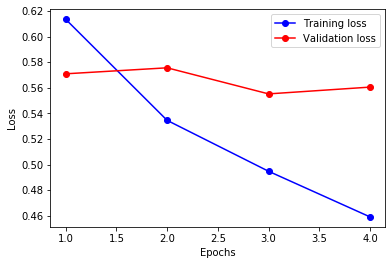

In [18]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Ploting training and validation accuracy.

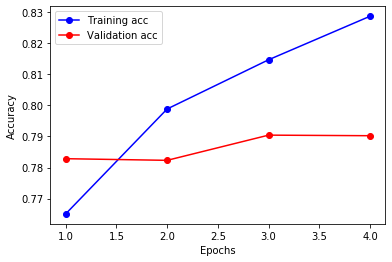

In [19]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo-', label='Training acc')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
prediction = model.predict_classes(test_sequences)

In [22]:
confusion_matrix(test_labels, prediction).T

array([[ 9294,  1328,  2055],
       [  711,   943,  1021],
       [ 3492,  2558, 32364]])

In [23]:
print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71     13497
           1       0.35      0.20      0.25      4829
           2       0.84      0.91      0.88     35440

    accuracy                           0.79     53766
   macro avg       0.64      0.60      0.61     53766
weighted avg       0.77      0.79      0.78     53766



In [24]:
cohen_kappa_score(test_labels ,prediction)

0.5538054977395568

### SimpleRNN model

In [25]:
model = Sequential()
model.add(Embedding(5000, 16))
model.add(SimpleRNN(16))
model.add(Dense(3, activation = 'softmax'))

In [26]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

In [27]:
history = model.fit(train_sequences, train_labels_cat, epochs = 3, batch_size=320, validation_split=0.2, verbose=0)

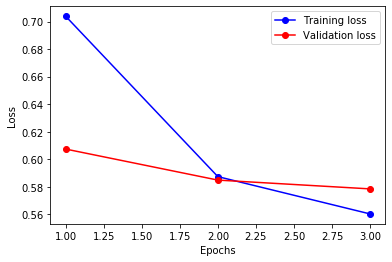

In [28]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

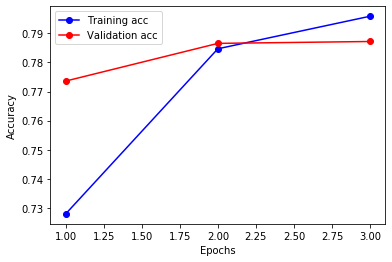

In [29]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo-', label='Training acc')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
prediction = model.predict_classes(test_sequences)

In [31]:
confusion_matrix(test_labels, prediction).T

array([[ 9248,  1693,  2105],
       [    0,     1,     1],
       [ 4249,  3135, 33334]])

In [32]:
print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70     13497
           1       0.50      0.00      0.00      4829
           2       0.82      0.94      0.88     35440

    accuracy                           0.79     53766
   macro avg       0.68      0.54      0.52     53766
weighted avg       0.76      0.79      0.75     53766



In [33]:
cohen_kappa_score(test_labels,prediction)

0.5271754077691267

# 7 Conclusions  <a class="anchor" id="cas-conclusion"></a>